In [681]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [682]:
# Constructors
def construct_P(series, L):
    T = len(series)
    num_cols = int(T/L)
    P = np.zeros((L, num_cols))
    for col in range(num_cols):
        P[:, col] = series[col*L : (1+col)*L]
    return P

def construct_P_hat(P, r):
    U, S, Vh = np.linalg.svd(P)
    S_r = np.diag(S)
    S_r[r:, r:] = 0
    S_r = np.hstack([S_r, np.zeros((S_r.shape[0], Vh.shape[0] - S_r.shape[1]))])
    P_hat = (U @ S_r @ Vh)
    return P_hat

# def construct_P_hat(P, r):
#     U, S, Vh = np.linalg.svd(P, full_matrices=False)
#     U_r = U[:, :r]
#     S_r = np.diag(S[:r])
#     Vh_r = Vh[:r, :]
#     P_hat = U_r @ S_r @ Vh_r
#     return P_hat

def construct_normalized_P_hat(series, L, r):
    P = construct_P(series, L)
    ior = inverse_observed_ratio(series)
    U, S, Vh = np.linalg.svd(P)
    S_r = np.diag(S)
    S_r[r:, r:] = 0
    S_r = np.hstack([S_r, np.zeros((S_r.shape[0], Vh.shape[0] - S_r.shape[1]))])
    P_hat = (U @ S_r @ Vh)
    print("P_hat.shape =", P_hat.shape)
    
    return P_hat * ior

def optimize_r(P):
    U, S, Vh = np.linalg.svd(P)
    arr = (S**2).cumsum() / (S**2).sum()
    print(arr)
    r = np.searchsorted(arr, 0.99, side='right')
    return r+1

def inverse_observed_ratio(series):
    num_missing = series.isnna().sum()
    return 1/(1 - num_missing/len(series))

def construct_stacked_P(df, L):
    """
    Constructs a stacked Page matrix from multiple series
    in a pd.DataFrame object.
    """
    stacked_P = np.hstack([construct_P(df.loc[:, col], L) for col in df.columns])
    return stacked_P

def construct_multi_stacked_P_for_test(df_train, df_test, L):
    n = df_test.shape[0]
    multi_stacked_P = []
    for i in range(n):
        # Start from i th row of df_train and the first i rows of df_test
        df_merged = pd.concat([df_train.iloc[i:, :], df_test.iloc[:i, :]], join="inner")
        # print("df_merged.shape =", df_merged.shape)
        multi_stacked_P.append(construct_stacked_P(df_merged, L))
    return multi_stacked_P

def construct_multi_stacked_P_hat_for_test(df_train, df_test, L, r):
    n = df_test.shape[0]
    multi_stacked_P_hat = []
    for i in range(n):
        df_merged = pd.concat([df_train.iloc[i:, :], df_test.iloc[:i, :]], join="inner")
        # print("df_merged.shape =", df_merged.shape)
        P = construct_stacked_P(df_merged, L)
        P_hat = construct_P_hat(P, r)
        multi_stacked_P_hat.append(P_hat)
    return multi_stacked_P_hat


In [683]:
# Calculators
def optimize_beta(P_hat):
    """
    Optimizes the beta coefficient vector such that
    linear combinations of all rows except the last rows
    give the last row with least squares error.
    """
    X = P_hat[:-1, :].T
    Y = P_hat[-1, :].T
    beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y)[:, np.newaxis]  # column vector
    # print("beta_hat.shape =", beta_hat)
    return beta_hat

def forecast_extra_row_SMOLS(P, P_hat):
    """
    Returns a forecast for an extra row for the Page matrix
    """
    # print("P_hat.shape in forecast =", P_hat.shape)
    X = P_hat[:-1, :].T
    Y = P[-1, :].T  # predict last row of the original matrix
    model = sm.OLS(Y, X).fit()
    beta_hat = model.params[:, np.newaxis]
    extra_row_forecast = (P[1:, :].T @ beta_hat).T
    # print("forecast row shape:", extra_row_forecast.shape)
    
    return extra_row_forecast  # return as a row

def MSE_short_term_test(df_train, df_test, L, r, forecast_col="s10_d83"):
    stacked_P_list = construct_multi_stacked_P_for_test(df_train, df_test, L)
    stacked_P_hat_list = construct_multi_stacked_P_hat_for_test(df_train, df_test, L, r)
    n, d = df_train.shape
    print("d =", d)
    # print("num columns stacked P =", stacked_P_list[5].shape[1])
    col_idx = df_test.columns.get_loc("s10_d83")
    print("col_idx =", col_idx)
    num_cols_P = int(stacked_P_list[5].shape[1] / d)
    print("num_cols_P =", num_cols_P)
    forecasts = []
    true_values = []
    MSE = 0
    for i, (P, P_hat) in enumerate(zip(stacked_P_list, stacked_P_hat_list)):
        forecast = forecast_extra_row_SMOLS(P, P_hat)[-1, (num_cols_P*(1+col_idx)-1)]
        forecasts.append(forecast)
        
        true_value = df_test.loc[:, forecast_col].iloc[i]
        true_values.append(true_value)
        MSE += (forecast - true_value)**2
    MSE = MSE / n
    MSE = np.round(MSE/1000, 2)
    
    plt.plot(true_values, label="True values", c="b")
    plt.plot(forecasts, label="forecasts", c="r")
    plt.title(f"$r={r}$, MSE = ${MSE}$ thousand")
    plt.legend()
    plt.grid()
    plt.show()
    
    return MSE

In [684]:
# Load datasets
train = pd.read_csv("data_walmart_train.csv", index_col="Date")
test = pd.read_csv("data_walmart_test.csv", index_col="Date")
missing_train = pd.read_csv("data_walmart_train_missing.csv", index_col="Date")
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
missing_train.index = pd.to_datetime(missing_train.index)

train.head(3)

,s1_d1,s1_d2,s1_d3,s1_d4,s1_d5,s1_d6,s1_d7,s1_d8,s1_d9,s1_d10,...,s10_d87,s10_d90,s10_d91,s10_d92,s10_d93,s10_d94,s10_d95,s10_d96,s10_d97,s10_d98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,50605.27,13740.12,39954.04,32229.38,5749.03,21084.08,40129.01,16930.99,30721.50,...,26394.89,16873.50,16363.10,54538.90,1337.33,22.15,77349.87,10576.00,6242.07,74.00
2010-02-12,46039.49,44682.74,10887.84,35351.21,29620.81,9135.00,18310.31,37334.83,16562.49,31494.77,...,22280.68,16145.65,14371.53,52893.10,1482.82,1531.13,71980.72,9385.66,6101.56,181.25
2010-02-19,41595.55,47928.89,11523.47,36826.95,26468.27,6060.26,19985.20,38717.60,15880.85,29634.13,...,22896.50,15874.73,13266.10,48087.25,1322.86,3627.75,71524.04,9871.61,5676.73,9.00


In [685]:
# Construct dataframes
df_s10_train = train.filter(like="s10").dropna(axis=1)
df_s10_test = test.filter(like="s10").dropna(axis=1)
df_s10_test = df_s10_test.loc[:, df_s10_train.columns]

print("Last train value of s10_d83")
print(df_s10_train.loc[:, "s10_d83"].iloc[-1])

print("First test value of s10_d83")
print(df_s10_test.loc[:, "s10_d83"].iloc[0])

Last train value of s10_d83
159.18
First test value of s10_d83
357.96


In [686]:
df_s10_train.loc[:, "s10_d83"].tail(3)

Date
2012-05-04    221.18
2012-05-11    237.16
2012-05-18    159.18
Name: s10_d83, dtype: float64

In [687]:
# Create stacked Page matrix.
L = 60
r = 1

print("Available columns for Store 10:", df_s10_train.shape[1])

stacked_P = construct_stacked_P(df_s10_train, L)
print("Stacked Page matrix shape:", stacked_P.shape)

stacked_P_hat = construct_P_hat(stacked_P, r)

forecast_extra_row_SMOLS(stacked_P, stacked_P_hat).shape

Available columns for Store 10: 67
Stacked Page matrix shape: (60, 134)


(1, 134)

In [688]:
df_s10_train.iloc[:, 57]

Date
2010-02-05    231.78
2010-02-12    266.68
2010-02-19    330.24
2010-02-26    252.28
2010-03-05    290.18
               ...  
2012-04-20    210.92
2012-04-27    254.00
2012-05-04    221.18
2012-05-11    237.16
2012-05-18    159.18
Name: s10_d83, Length: 120, dtype: float64

d = 67
col_idx = 57
num_cols_P = 2


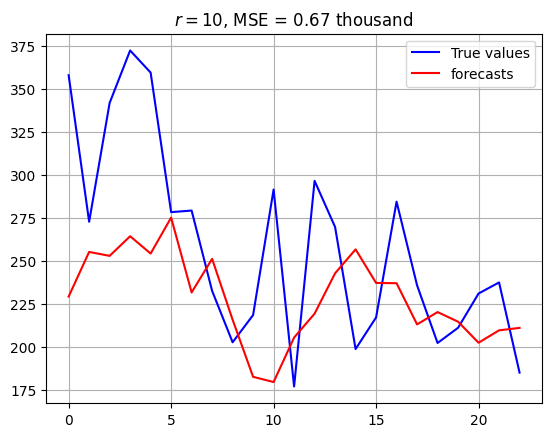

0.67

In [689]:
L = 60  # Window length
r = 10  # Rank for approximation
forecast_col = "s10_d83"

MSE_short_term_test(df_s10_train, df_s10_test, L, r, forecast_col)